In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from dataclasses import dataclass

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    """Helper function to plot our time series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)


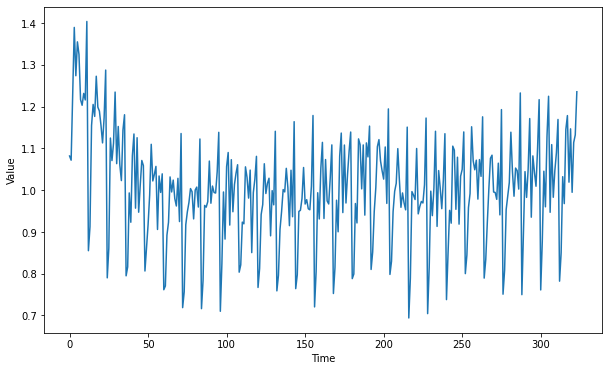

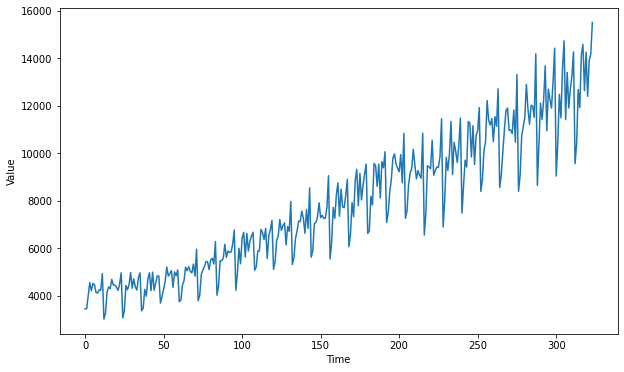

In [ ]:
def generate_time_series():
  df = pd.read_csv('/content/Detrended_alcohol.csv', usecols=["DETR1"], sep = ';')
  series = df.to_numpy().flatten()

  time = np.arange(series.size, dtype="float32")
    
  return time, series

def generate_time_series_ori():
  df = pd.read_csv('/content/Detrended_alcohol.csv', usecols=["S4248SM144NCEN"], sep = ';')
  series = df.to_numpy().flatten()

  time = np.arange(series.size, dtype="float32")
    
  return time, series

# Here are the detrended data
# Let's save the parameters of our time series in the dataclass
@dataclass
class G:
    TIME, SERIES = generate_time_series()
    SPLIT_TIME = 278 # on data 278 the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 12 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 24 # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer

# Here are the original data
@dataclass
class ORI:
    TIME, SERIES = generate_time_series_ori()
    SPLIT_TIME = 278 # on data 278 the training period will end. The rest will belong to the validation set
    WINDOW_SIZE = 12 # how many data points will we take into account to make our prediction
    BATCH_SIZE = 24 # how many items will we supply per batch
    SHUFFLE_BUFFER_SIZE = 1000 # we need this parameter to define the Tensorflow sample buffer
    
    
# plot the series
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

# plot the series
plt.figure(figsize=(10, 6))
plot_series(ORI.TIME, ORI.SERIES)
plt.show()

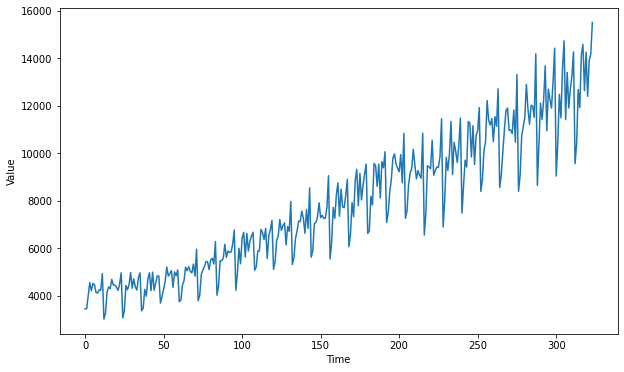

In [ ]:
t = 1
test = np.array([])
for x in G.SERIES:
  new =  np.multiply(x, (3168,1 + 28,9*t))
  test = np.append(test, new)
  t+=1
plt.figure(figsize=(10, 6))
plot_series(ORI.TIME, ORI.SERIES)
plt.show()

# Model

In [ ]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):
	"""Divide the time series into training and validation set"""
	time_train = time[:time_step]
	series_train = series[:time_step]
	time_valid = time[time_step:]
	series_valid = series[time_step:]

	return time_train, series_train, time_valid, series_valid

def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
	"""
	We create time windows to create X and y features.
	For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
	"""
	dataset = tf.data.Dataset.from_tensor_slices(series)
	dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
	dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
	dataset = dataset.shuffle(shuffle_buffer)
	dataset = dataset.map(lambda window: (window[:-1], window[-1]))
	dataset = dataset.batch(batch_size).prefetch(1)
	return dataset

In [ ]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)
ori_time_train, ori_series_train, ori_time_valid, ori_series_valid = train_val_split(ORI.TIME, ORI.SERIES)

# let's create the dataset with time windows
dataset = windowed_dataset(series_train)

In [ ]:
def create_uncompiled_model():
  # define a sequential model
  model = tf.keras.models.Sequential([ 
      tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                    input_shape=[None]),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
      tf.keras.layers.Dense(1),
  ]) 

  return model

In [ ]:
class EarlyStopping(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    
    if(logs.get('mae') < 0.03):
      print("\nMAEthreshold reached. Training stopped.")
      self.model.stop_training = True

# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [ ]:
def create_model():
    tf.random.set_seed(51)
  
    model = create_uncompiled_model()
  
    model.compile(loss=tf.keras.losses.Huber(), 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mae"])  
    return model
  
model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 2048)       8404992   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 1024)       10489856  
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 512)        2623488   
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 256)        656384    
 nal)                                                   

In [ ]:
history = model.fit(dataset, epochs=53, callbacks=[early_stopping])

Epoch 1/53
12/12 [==============================] - 21s 69ms/step - loss: 0.1331 - mae: 0.4041
Epoch 2/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0097 - mae: 0.1114
Epoch 3/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0096 - mae: 0.1126
Epoch 4/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0085 - mae: 0.1061
Epoch 5/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0074 - mae: 0.0956
Epoch 6/53
12/12 [==============================] - 0s 34ms/step - loss: 0.0069 - mae: 0.0929
Epoch 7/53
12/12 [==============================] - 0s 34ms/step - loss: 0.0069 - mae: 0.0923
Epoch 8/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0077 - mae: 0.0995
Epoch 9/53
12/12 [==============================] - 0s 34ms/step - loss: 0.0074 - mae: 0.0967
Epoch 10/53
12/12 [==============================] - 0s 35ms/step - loss: 0.0068 - mae: 0.0928
Epoch 11/53
12/12 [==============================] - 0s 35

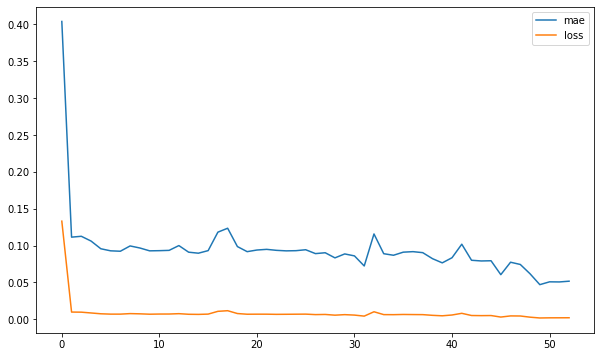

In [ ]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [ ]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()

    return mse, mae, mape

def model_forecast(model, series, window_size):
    """This function converts the input series into a dataset with time windows for forecasting"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

10/10 [==============================] - 3s 23ms/step


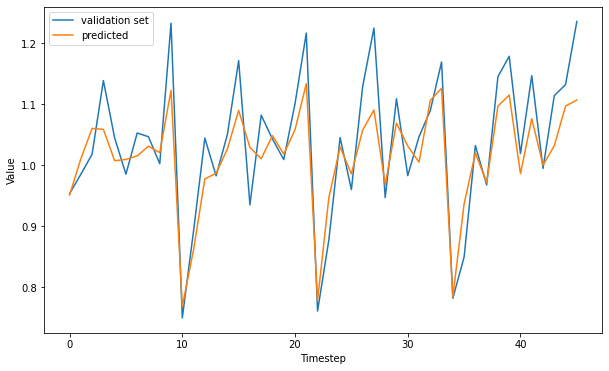

In [ ]:
# Prediction on the whole series with decomposition
all_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(series_valid, label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
mse, mae, mape = compute_metrics(series_valid, val_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f}, mape: {mape:.2f}")

mse: 0.00, mae: 0.04, mape: 4.14


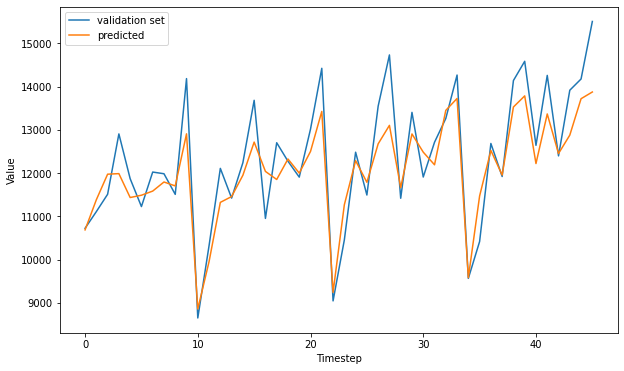

In [ ]:
# translate decomposition to real value
t = 279
val_ori_forecast = np.array([])
for x in val_forecast:
  new =  np.multiply(x, (3168.1 + 28.9*t))
  val_ori_forecast = np.append(val_ori_forecast, new)
  t+=1

# Plot
plt.figure(figsize=(10, 6))
plt.plot(ori_series_valid, label="validation set")
plt.plot(val_ori_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [ ]:
# result with original data
mse, mae, mape = compute_metrics(ori_series_valid, val_ori_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f}, mape: {mape:.2f}")

mse: 452988.86, mae: 532.31, mape: 4.16


1/1 [==============================] - 0s 24ms/step


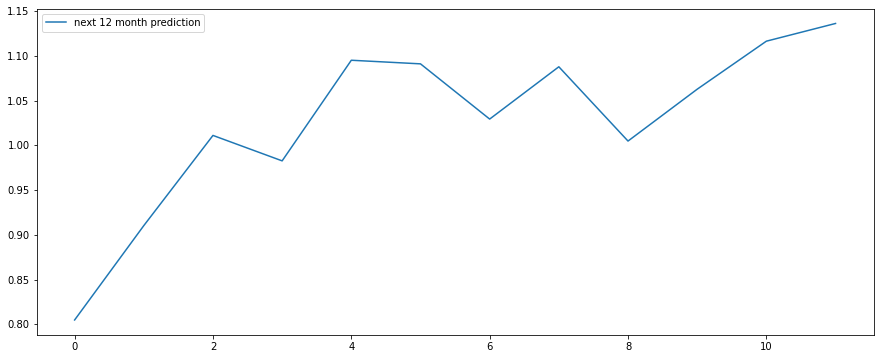

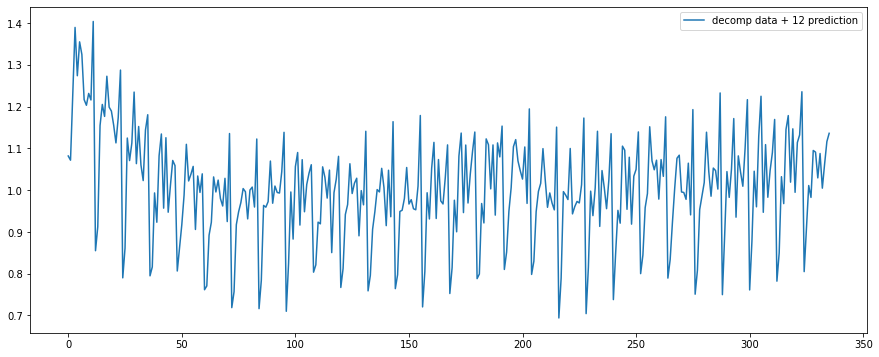

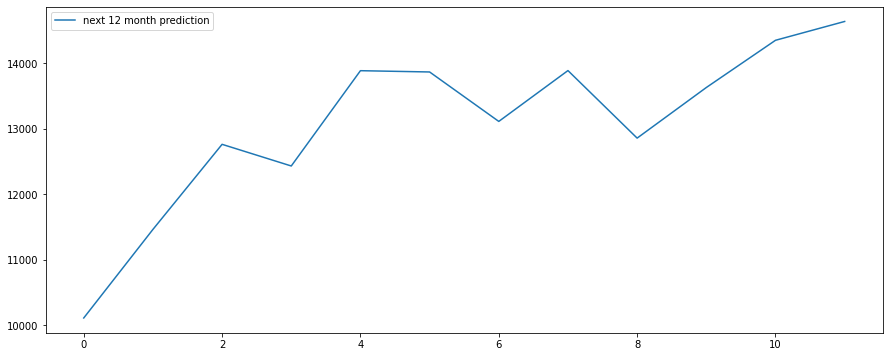

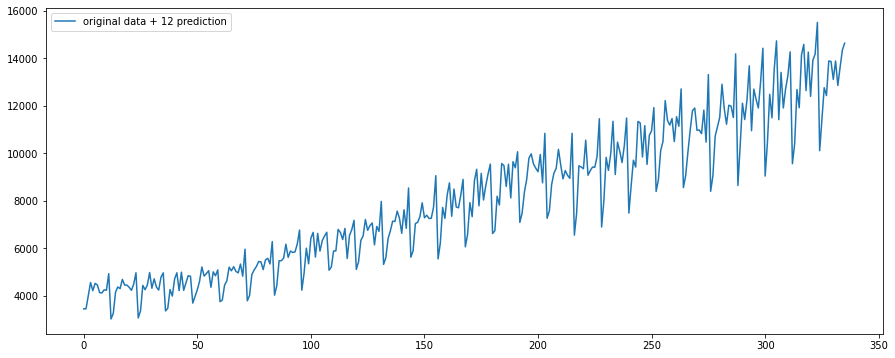

In [ ]:
series_tmp = G.SERIES
series_ori_pred = ORI.SERIES
for x in range(12):
  new_forecast = []
  new_forecast_series = series_tmp[-12:] 
  pred = model.predict(new_forecast_series[np.newaxis])
  series_tmp = np.append(series_tmp, pred)
  series_ori_pred = np.append(series_ori_pred,np.multiply(pred, (3168.1 + 28.9*(series_ori_pred.size+1))))

plt.figure(figsize=(15, 6))
plt.plot(series_tmp[-12:], label="next 12 month prediction")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(series_tmp, label="decomp data + 12 prediction")
plt.legend()
plt.show()


plt.figure(figsize=(15, 6))
plt.plot(series_ori_pred[-12:], label="next 12 month prediction")
plt.legend()
plt.show()

plt.figure(figsize=(15, 6))
plt.plot(series_ori_pred, label="original data + 12 prediction")
plt.legend()
plt.show()